## Классификация изображений
### Вводные слова
Задача классификации изображений - это одна из ключевых задач в области компьютерного зрения и машинного обучения. Она заключается в том, чтобы разработать модель, способную автоматически определить, к какому классу или категории принадлежит данное изображение. Классификация используется в следующих задачах: классификация спектрограмм музыкальных записей для выявления предпочтений конкретного пользователя, классификация изображений для автоматической идентификации людей на фотографиях, кластеризация покупок пользователя в интернет-магазине для формирования целевой рекламы, и так далее
### Рекомендации
Работу лучше выполнять в среде Google Colab, поскольку потребуется осуществлять вычисления на видеокарте. В Colab в меню нажмите на Изменить->Настройки блокнота и выберите доступный GPU. Это позволит использовать для обучения CUDA
### Цель работы и задачи
В данной работе мы разработаем модель, для предсказания класса на датасете cifar-10. Ниже будет представлена baseline модель, основываясь на которой вы можете строить свою модель для классификации
\
Задачи, которые вам нужно решить в работе:
\
Обязательные:
- Построить распределение классов в данных
- Подготовить данные и обучить baseline-модель на датасете
- Оценить качество модели
- Написать свою модель и обучить ее

Желательные:
- Подумать об архитектуре модели, быть может стоит сделать ее глубже, добавить боковые связи и т.д.
- Задуматься об аугментации
- Попробовать transfer-learning

\
\
Ваша работа будет оцениваться исходя из 2 факторов:
- контрольная метрика
- протокол исследования, которым и будет служить этот Jupyter-Notebook

\
Максимальный балл за работу - 20.
\
Удачи!

## Baseline-модель

In [1]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.functional import F

Обучать мы будем, разумеется, на cuda, поэтому, создадим переменную device, которая будет зависеть от того, доступна ли видеокарта для вычислений

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

# Функция для подсчета числа параметров
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Running on cpu


In [3]:
class Baseline(nn.Module):
    def __init__(self, num_classes=10):
        super(Baseline, self).__init__()
        # Сверточные слои
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Полносвязные слои
        self.fc1 = nn.Linear(in_features=32 * 8 * 8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
    
    def forward(self, x):
        # Прямой проход через сверточные слои
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        
        # Вытягивание в одномерный вектор
        x = x.view(x.size(0), -1)
        
        # Прямой проход через полносвязные слои
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

Загрузим данные, построим диаграммы для распределения классов и посмотрим на сами картинки

100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


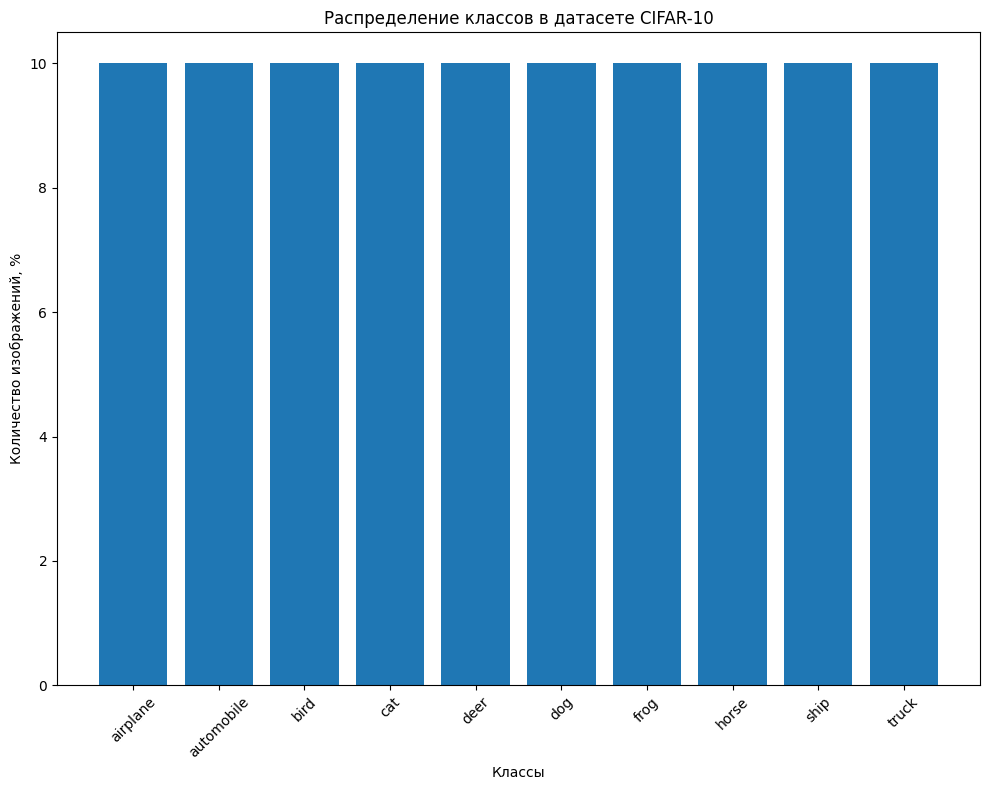

In [4]:
# Будем превращать картинку в torch.Tensor
transform = transforms.ToTensor()

# Загрузим датасеты для train и test
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Получим метки классов
class_labels = train_dataset.classes
class_counts = np.array([0] * len(class_labels))

# Посчитаем число меток классов
for _, label in train_dataset:
    class_counts[label] += 1

class_counts = class_counts / class_counts.sum() * 100

# Построим диаграмму
plt.figure(figsize=(10, 8))
plt.bar(class_labels, class_counts) # (?, ?)
plt.xlabel('Классы')
plt.ylabel('Количество изображений, %')
plt.title('Распределение классов в датасете CIFAR-10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

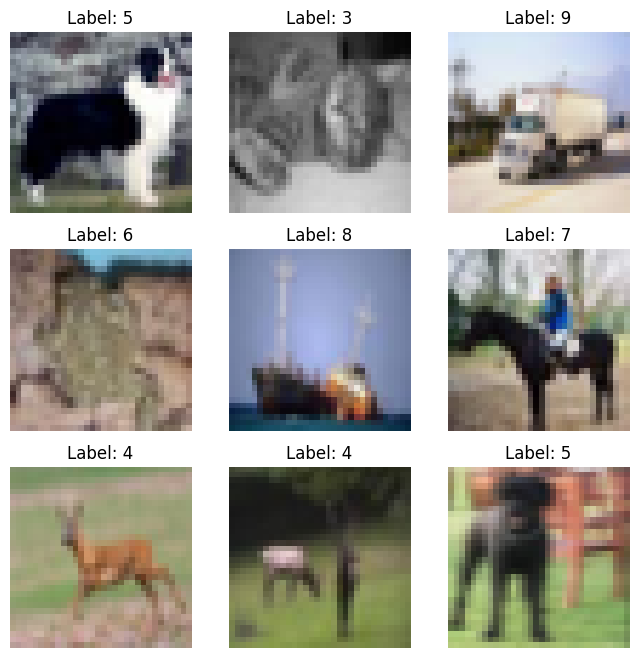

In [5]:
indices = np.random.choice(len(train_dataset), 9, replace=False)

# Создайте сетку 3x3 для отображения изображений
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[indices[i]]
    image = image.numpy().transpose((1, 2, 0))  # Перевести изображение из формата (C, H, W) в (H, W, C)
    ax.imshow(image)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()

Сделайте вывод о сбалансированности датасета:
\
Исходя из этого, какие метрики будем применять для оценки качества модели?

Напишем функции train и test

In [15]:
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split

# Оптимизация AUC
class Baseline(nn.Module):
    def __init__(self, num_classes):
        super(Baseline, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Функция обучения с вычислением AUC

def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    train_loss_history, train_auc_history = [], []
    val_loss_history, val_auc_history = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        y_true, y_pred = [], []

        pbar = tqdm(train_loader, ncols=100, desc=f'Train Epoch {epoch + 1}/{epochs}')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.softmax(dim=1).detach().cpu().numpy())

            pbar.set_postfix(loss=running_loss / len(train_loader))

        train_loss_history.append(running_loss / len(train_loader))

        if len(set(y_true)) > 2:
            train_auc = roc_auc_score(y_true, y_pred, multi_class='ovr')
        else:
            train_auc = roc_auc_score(y_true, [p[1] for p in y_pred])

        train_auc_history.append(train_auc)

        # Валидация
        model.eval()
        val_loss = 0.0
        y_true, y_pred = [], []
        with torch.no_grad():
            pbar = tqdm(val_loader, ncols=100, desc=f'Val Epoch {epoch + 1}/{epochs}')
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(outputs.softmax(dim=1).cpu().numpy())

        val_loss_history.append(val_loss / len(val_loader))

        if len(set(y_true)) > 2:
            val_auc = roc_auc_score(y_true, y_pred, multi_class='ovr')
        else:
            val_auc = roc_auc_score(y_true, [p[1] for p in y_pred])

        val_auc_history.append(val_auc)

        print(f'Epoch {epoch + 1}/{epochs}, Train AUC: {train_auc:.4f}, Val AUC: {val_auc:.4f}')

    return train_loss_history, train_auc_history, val_loss_history, val_auc_history

# Проверка и преобразование меток, если необходимо
def transform_labels(dataset, positive_label=1):
    for i in range(len(dataset)):
        _, label = dataset[i]
        dataset[i] = (dataset[i][0], 1 if label == positive_label else 0)

# Загрузка данных и создание DataLoader
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Автоматическое определение количества классов
unique_labels = set(label for _, label in train_dataset)
num_classes = len(unique_labels)
print(f"Detected number of classes: {num_classes}")

# Если задача бинарная, преобразуем метки
if num_classes == 2:
    transform_labels(train_dataset, positive_label=1)  # Указываем положительный класс
    transform_labels(val_dataset, positive_label=1)
    transform_labels(test_dataset, positive_label=1)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Настройка гиперпараметров
learning_rate = 0.0001
num_epochs = 15

model = Baseline(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Обучение
train_loss_history, train_auc_history, val_loss_history, val_auc_history = train(
    model, train_loader, val_loader, criterion, optimizer, device, epochs=num_epochs
)


Detected number of classes: 10


Val Epoch 1/15: 100%|███████████████████████████████████████████████| 57/57 [00:01<00:00, 49.95it/s]


Epoch 1/15, Train AUC: 0.6883, Val AUC: 0.7716


Val Epoch 2/15: 100%|███████████████████████████████████████████████| 57/57 [00:01<00:00, 48.90it/s]


Epoch 2/15, Train AUC: 0.7949, Val AUC: 0.8184


Val Epoch 3/15: 100%|███████████████████████████████████████████████| 57/57 [00:01<00:00, 50.00it/s]


Epoch 3/15, Train AUC: 0.8295, Val AUC: 0.8349


Val Epoch 4/15: 100%|███████████████████████████████████████████████| 57/57 [00:01<00:00, 44.52it/s]


Epoch 4/15, Train AUC: 0.8473, Val AUC: 0.8511


Val Epoch 5/15: 100%|███████████████████████████████████████████████| 57/57 [00:01<00:00, 41.14it/s]


Epoch 5/15, Train AUC: 0.8583, Val AUC: 0.8600


Val Epoch 6/15: 100%|███████████████████████████████████████████████| 57/57 [00:01<00:00, 43.49it/s]


Epoch 6/15, Train AUC: 0.8684, Val AUC: 0.8681


Val Epoch 7/15: 100%|███████████████████████████████████████████████| 57/57 [00:01<00:00, 35.83it/s]


Epoch 7/15, Train AUC: 0.8764, Val AUC: 0.8728


Val Epoch 8/15: 100%|███████████████████████████████████████████████| 57/57 [00:01<00:00, 33.73it/s]


Epoch 8/15, Train AUC: 0.8824, Val AUC: 0.8797


Val Epoch 9/15: 100%|███████████████████████████████████████████████| 57/57 [00:01<00:00, 43.16it/s]


Epoch 9/15, Train AUC: 0.8891, Val AUC: 0.8849


Val Epoch 10/15: 100%|██████████████████████████████████████████████| 57/57 [00:01<00:00, 44.46it/s]


Epoch 10/15, Train AUC: 0.8945, Val AUC: 0.8895


Val Epoch 11/15: 100%|██████████████████████████████████████████████| 57/57 [00:01<00:00, 35.91it/s]


Epoch 11/15, Train AUC: 0.8993, Val AUC: 0.8923


Val Epoch 12/15: 100%|██████████████████████████████████████████████| 57/57 [00:01<00:00, 33.66it/s]


Epoch 12/15, Train AUC: 0.9039, Val AUC: 0.8954


Val Epoch 13/15: 100%|██████████████████████████████████████████████| 57/57 [00:01<00:00, 33.95it/s]


Epoch 13/15, Train AUC: 0.9064, Val AUC: 0.8929


Val Epoch 14/15: 100%|██████████████████████████████████████████████| 57/57 [00:01<00:00, 34.67it/s]


Epoch 14/15, Train AUC: 0.9107, Val AUC: 0.9002


Val Epoch 15/15: 100%|██████████████████████████████████████████████| 57/57 [00:01<00:00, 44.51it/s]

Epoch 15/15, Train AUC: 0.9137, Val AUC: 0.9030


Сделайте разделение на train и val
\
Зачем так делать?

Создайте Dataloader'ы и настройте гиперпараметры, оптимизатор и функцию потерь
\
Какой оптимизатор будете использовать и почему, а какую loss-функцию?

Обучите модель и постройте графики обучения

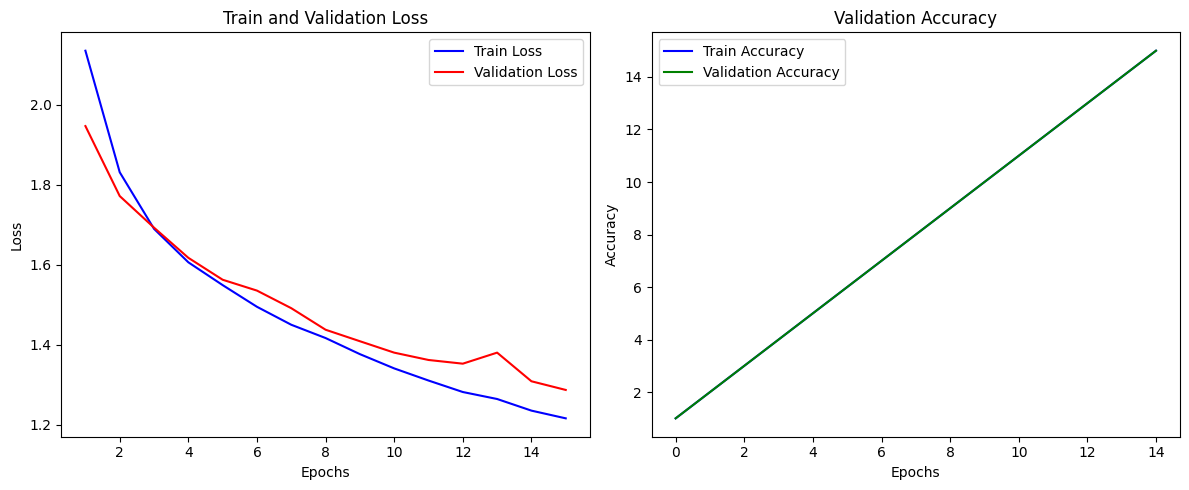

In [16]:
epochs = range(1, len(train_loss_history) + 1)

# График функции потерь на тренировочных данных
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b', label='Train Loss')
plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности на валидационных данных
plt.subplot(1, 2, 2)
plt.plot(epochs,  'b', label='Train Accuracy')
plt.plot(epochs, 'g', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Сделайте выводы о качестве обучения

Оцените тестовую метрику на тестовых данных

## Что дальше?
Теперь, когда у вас есть все необходимое - экспериментируйте. Можете изменить все что угодно, креативность поощряется. Используйте новые модели, loss-функции, аугментацию, ансамбли, выдумывайте все, что сможете

## Критерии оценки
Accuracy - на тестовых данных
- $Accuracy \leq 0.67$ - 0 баллов
- $0.67 < Accuracy \leq 0.72$ - 2 балла
- $0.72 < Accuracy \leq 0.77$ - 4 балла
- $0.77 < Accuracy \leq 0.82$ - 6 баллов
- $0.82 < Accuracy \leq 0.87$ - 8 баллов
- $Accuracy > 0.87$ - 10 баллов